## 1. Выбор и описание датасета

На данном этапе производится загрузка датасета и его описание, а также постановка решаемой задачи.

Для выполнения работы был выбран датасет RuSentiment — это корпус сообщений из социальной сети «ВКонтакте», размеченных вручную по эмоциональной тональности. Датасет широко используется для обучения и оценки моделей в задачах анализa тональности текста на русском языке.
Изначально датасет включает следующие метки:

- `positive` — положительная оценка или настроение;
- `neutral` — нейтральное сообщение;
- `negative` — негативная оценка или настроение;
- `speech` — речевые акты (поздравления, благодарности);
- `skip` — пропущенные, неанализируемые или неуместные сообщения.

В данной работе используются только три основные метки, поскольку они соответствуют постановке задачи классификации по эмоциональной окраске текста. Задача — разработать и сравнить модели машинного обучения для многоклассовой классификации сообщений по тональности. 
Используемые метки:

- `positive`,
- `neutral`,
- `negative`.

In [29]:
import pandas as pd

# Загрузка датасета
df = pd.read_csv('data/rusentiment_random_posts.csv')

# Предварительный просмотр
df.head(10)

,label,text
0,negative,"А попа подозревала давно,что ты с кавказа..пер..."
1,speech,З прошедшим Днем Ангела))))))))
2,skip,Два дня до отлёта с острова!!!!!!!
3,negative,"Блин, почему эта жизнь столь не справедлива (((("
4,skip,где еще встречать свой день рождения как не на...
5,neutral,Решите уравнение мужских дел для жизни :\nДомо...
6,positive,патамушта я крутая баба! ееее!!
7,neutral,Просто пост :)
8,positive,урря!я дождался этой овцыы)
9,speech,"С Днем Рождения желаю много счастья, любви и у..."


# 2. Предварительный анализ и очистка данных

Проверка датасета на наличие пропущенных значений и дублирующихся записей, а также отбор целевых меток. Из анализа исключаются сообщения, не содержащие текст или размеченные как нерелевантные (`speech`, `skip`).

Также оценивается распределение классов.

### 2.1 Количественные характеристики и структура данных

In [30]:
# Количественные характеристики
print("Общее количество записей:", len(df))
print("Число уникальных классов:", df['label'].nunique())
print("\nРаспределение классов:")
print(df['label'].value_counts())

Общее количество записей: 21268
Число уникальных классов: 5

Распределение классов:
label
neutral     8323
positive    4635
skip        3190
speech      2826
negative    2294
Name: count, dtype: int64


`text` — входной признак, `label` — целевая переменная для обучения модели.

### 2.2 Проверка и очистка данных

In [31]:
# Удаление нерелевантных меток
df = df[df['label'].isin(['positive', 'neutral', 'negative'])]

# Проверка пропущенных значений и дубликатов
print("Пропущенные значения:", df['text'].isnull().sum())
print("Дубликатов:", df.duplicated().sum())

# Удаление пропусков и дубликатов
df.dropna(subset=['text'], inplace=True)
df.drop_duplicates(inplace=True)

print("Размерность после очистки:", df.shape)

Пропущенные значения: 0
Дубликатов: 35
Размерность после очистки: (15217, 2)


### 2.3 Анализ распределения классов

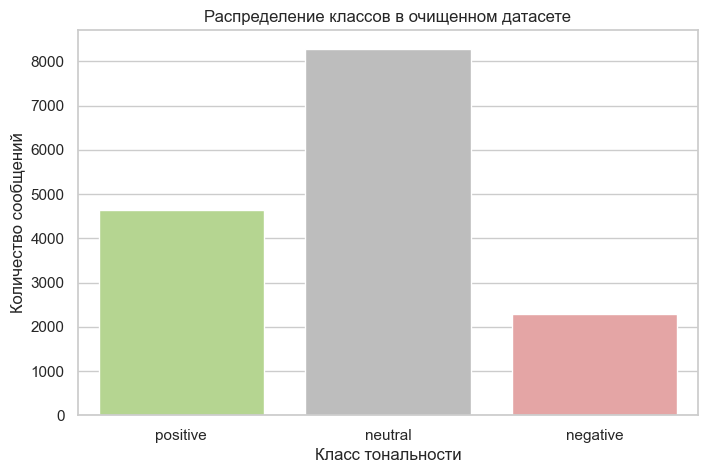

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
custom_palette = {
    'positive': "#B6E086", 
    'neutral':  '#BDBDBD', 
    'negative': '#EF9A9A' 
}

# Построение диаграммы распределения
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    x='label',
    hue='label',
    order=['positive', 'neutral', 'negative'],
    palette=custom_palette,
    legend=False
)
plt.title('Распределение классов в очищенном датасете')
plt.xlabel('Класс тональности')
plt.ylabel('Количество сообщений')
plt.show()

In [33]:
# Вывод процентного распреления классов
class_counts = df['label'].value_counts()
class_percentages = df['label'].value_counts(normalize=True) * 100

class_distribution = pd.DataFrame({
    'Количество': class_counts,
    'Доля (%)': class_percentages.round(2)
})

print("Распределение классов:")
display(class_distribution)

Распределение классов:


,Количество,Доля (%)
label,,
neutral,8291,54.49
positive,4632,30.44
negative,2294,15.08


В результате анализа установлено, что нейтральные сообщения составляют наибольшую долю в выборке. Это может потребовать применения методов балансировки данных на последующих этапах.

### 2.4 Кодирование целевой переменной

In [34]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Сопоставление меток:")
for label, code in label_map.items():
    print(f"{label} → {code}")

Сопоставление меток:
negative → 0
neutral → 1
positive → 2


### 2.5 Примеры данных

In [35]:
for label in ['positive', 'neutral', 'negative']:
    print(f"\nПримеры {label.upper()}:")
    samples = df[df['label'] == label]['text'].dropna().sample(3)
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text}")


Примеры POSITIVE:
1. Я стал еще сильнее. Теперь я 155 уровень! Скоро ни один безумец не будет проблемой для меня.
2. АХАХХАХАХАХААХАХХАХАХАХАХАХАХАХАХ
3. :Р  а мы сходили в суши:Р и ОБЪЕЛИСЬ;D

Примеры NEUTRAL:
1. Вы все еще хотите отдать своих детей в музыкальную школу?
2. Продаю универсальный обьектив, для Canon. Легкий, быстрый!
3. шантажист))

Примеры NEGATIVE:
1. индивидуалку мне запили, блеать!!!
2. хуево что она меня не любит
3. привет,я не послушал ефир играли в реслинг я свихнул руку


# 3. Преобразование признаков (векторизация текста)

На данном этапе выполняется предобработка и  последующая векторизация текстов с помощью TF-IDF (Term Frequency–Inverse Document Frequency), которая отражает важность слов относительно каждого документа и всей выборки в целом.

TF-IDF позволяет учитывать как частотность слова в конкретном сообщении, так и его редкость по корпусу, что делает модель более устойчивой к часто встречающимся словам и выделяет информативные признаки.


### 3.1 Предобработка текста

Исходные сообщения содержат пунктуацию, смайлики, хештеги и символы, не несущие полезной смысловой нагрузки. Для повышения качества признаков производится очистка текста:
- приведение к нижнему регистру;
- удаление пунктуации и неалфавитных символов;
- лемматизация слов с использованием библиотеки `pymorphy3`;
- удаление стоп-слов (по списку NLTK).


In [36]:
import re
import pymorphy3
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk_data_path = "data/nltk"
nltk.data.path.append(nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)

morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words("russian"))
punctuation = r"[^\w\s]"

[nltk_data] Downloading package punkt to data/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to data/nltk...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to data/nltk...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление пунктуации и лишних символов
    text = re.sub(punctuation, ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Токенизация
    tokens = word_tokenize(text)

    # Лемматизация + фильтрация стоп-слов
    lemmas = [
        morph.parse(token)[0].normal_form
        for token in tokens
        if token not in stop_words and token.isalpha()
    ]

    return ' '.join(lemmas)


In [38]:
df['text_preprocessed'] = df['text'].apply(preprocess_text)
df[['text', 'text_preprocessed']].head(10)

,text,text_preprocessed
0,"А попа подозревала давно,что ты с кавказа..пер...",поп подозревать давно кавказ перестать общатьс...
3,"Блин, почему эта жизнь столь не справедлива ((((",блин почему этот жизнь столь справедливый
5,Решите уравнение мужских дел для жизни :\nДомо...,решить уравнение мужской дело жизнь дом дерево...
6,патамушта я крутая баба! ееее!!,патамушт крутой баба ееий
7,Просто пост :),просто пост
8,урря!я дождался этой овцыы),уррить дождаться овцы
11,Наша гордость !,наш гордость
13,"Походу, первым кто поздравил меня с 1 апреля -...",поход первый поздравить апрель это ржд мина жд...
14,познакомил свою девушку с Ксюшей,познакомить девушка ксюша
18,Тесака арестовали...,тесак арестовать


### 3.2 Векторизация TF-IDF

Для векторизации текстов используется схема TF-IDF с диапазоном `ngram_range=(1, 2)` для учёта как отдельных слов (униграмм), так и устойчивых словосочетаний (биграмм), что особенно актуально в задачах анализа тональности.
Ограничение `max_features=10000` введено с целью исключения редких и нерелевантных слов, а также для уменьшения размерности признакового пространства и повышения устойчивости модели.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

russian_stopwords = stopwords.words("russian")

# Векторизация текста
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),     # униграммы и биграммы
    max_features=10000,     # ограничение на размер словаря
    stop_words=russian_stopwords
)

X = vectorizer.fit_transform(df['text'])
y = df['label_encoded']

print(f"Размерность матрицы признаков: {X.shape}")

Размерность матрицы признаков: (15217, 10000)


В данном пункте была продемонстрирована реализация векторизации текста вручную с использованием TF-IDF, как отдельного этапа обработки. Однако при построении полного процесса обучения моделей в рамках сравнения алгоритмов, используется программный конвейер (`Pipeline`) из библиотеки `scikit-learn`, объединяющий этапы преобразования текста и обучения классификатора.

# 4. Описательный анализ признаков

Поскольку в данной задаче все входные признаки являются результатом векторизации текста методом TF-IDF, они имеют интервальную шкалу измерения и представляют собой числовые значения в диапазоне от 0 до 1. Каждый признак соответствует частотной характеристике отдельного слова или сочетания слов в тексте, и не обладает фиксированной смысловой интерпретацией.

Полноценный описательный анализ, включая проверку нормальности, корреляционный анализ и визуализацию каждого признака, не представляется целесообразным в данной постановке задачи. Это связано с высокой размерностью признакового пространства (10 000 признаков) и тем, что признаки не обладают явным физическим смыслом или шкалой.

В качестве вспомогательного анализа проведено изучение распределения длины сообщений по числу символов и слов, так как это может опосредованно влиять на характер векторных представлений.


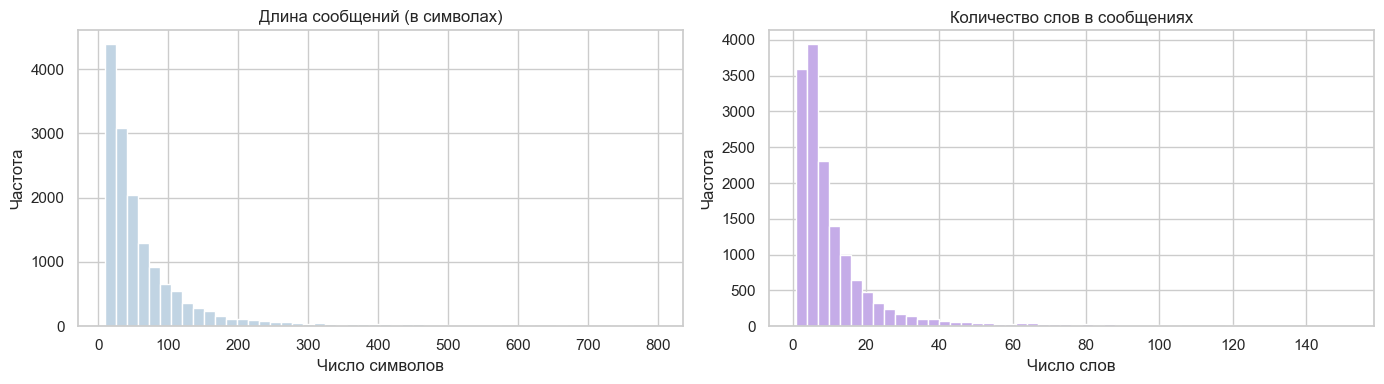

In [41]:
# Расчёт длины сообщений
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Распределение по числу символов
axes[0].hist(df['text_length'], bins=50, color="#C1D4E3")
axes[0].set_title("Длина сообщений (в символах)")
axes[0].set_xlabel("Число символов")
axes[0].set_ylabel("Частота")

# Распределение по числу слов
axes[1].hist(df['word_count'], bins=50, color='#C5ACE8')
axes[1].set_title("Количество слов в сообщениях")
axes[1].set_xlabel("Число слов")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()


Большинство сообщений содержат от 5 до 20 слов и менее 150 символов. Это подтверждает, что сообщения короткие, что типично для пользовательского контента в социальных сетях. Данный анализ дополнительно обосновывает выбор параметров TF-IDF и ограничение словаря до 10 000 признаков.

# 5. Методы обучения без учителя

Данный пункт не реализован в рамках работы, поскольку исследуемая задача предполагает наличие размеченной выборки и решается методами обучения с учителем. Все сообщения снабжены метками эмоциональной тональности, и основной целью является построение и сравнение моделей классификации. 

# 6. Разделение выборки на обучающую и тестовую

В рамках данной работы используется случайное разбиение выборки на обучающую и тестовую части. Размер тестовой выборки составляет 20%.

Для сохранения пропорций классов в обеих выборках используется стратифицированное разбиение (Stratified Split), что позволяет предотвратить смещение модели в сторону доминирующего класса.


In [42]:
df.head(10)

,label,text,label_encoded,text_preprocessed,text_length,word_count
0,negative,"А попа подозревала давно,что ты с кавказа..пер...",0,поп подозревать давно кавказ перестать общатьс...,69,10
3,negative,"Блин, почему эта жизнь столь не справедлива ((((",0,блин почему этот жизнь столь справедливый,48,8
5,neutral,Решите уравнение мужских дел для жизни :\nДомо...,1,решить уравнение мужской дело жизнь дом дерево...,76,16
6,positive,патамушта я крутая баба! ееее!!,2,патамушт крутой баба ееий,31,5
7,neutral,Просто пост :),1,просто пост,14,3
8,positive,урря!я дождался этой овцыы),2,уррить дождаться овцы,27,4
11,positive,Наша гордость !,2,наш гордость,15,3
13,negative,"Походу, первым кто поздравил меня с 1 апреля -...",0,поход первый поздравить апрель это ржд мина жд...,77,15
14,neutral,познакомил свою девушку с Ксюшей,1,познакомить девушка ксюша,32,5
18,negative,Тесака арестовали...,0,тесак арестовать,21,2


In [43]:
from sklearn.model_selection import train_test_split

# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(
    df["text_preprocessed"], 
    df["label_encoded"],
    test_size=0.2,
    stratify=df["label_encoded"],
    random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 12173
Размер тестовой выборки: 3044


# 7. Обучение и сравнение моделей

На данном этапе производится обучение и сравнение семи различных моделей классификации, применимых к задаче анализа тональности текстов. Для обеспечения воспроизводимости, единообразия и компактности реализации используется программный конвейер (`Pipeline`) из библиотеки `scikit-learn`, включающий векторизацию текста методом TF-IDF и последующую классификацию.

Обучение проводится на предобработанном тексте (`text_preprocessed`) с использованием заранее сформированного списка русских стоп-слов. Для оценки эффективности моделей используются метрики `accuracy`, `F1-мера`, `precision`, `recall`, а также замеряется время обучения каждой модели.

In [50]:
import time
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

models = {
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "LinearSVC": LinearSVC(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "Logistic Regression": LogisticRegression(),
    "SGD Classifier": SGDClassifier()
}


### 7.1 Обучение моделей и оценка качества

Ниже проводится цикл обучения всех моделей с замером времени и расчётом основных метрик. Все этапы включены в единый программный конвейер.

In [53]:
# Хранилище результатов
results = []

# Обучение и оценка моделей
for name, model in models.items():
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 3), stop_words=russian_stopwords)),
        ("clf", model)
    ])
    
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    fit_time = time.time() - start_time

    y_pred = pipeline.predict(X_test)

    results.append({
        "Модель": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "Время обучения, с": round(fit_time, 2)
    })

Выбор таких (взвешенных) метрик, как `F1-score`, `Precision` и `Recall` с параметром `average='weighted'`, объясняется тем, что в [п. 2.3](###23-анализ-распределения-классов) было зафиксировано следующее распределение классов: класс `neutral` значительно преобладает над `positive` и особенно `negative`.

В таких условиях использование обычного `accuracy` или усреднения `macro`, которое даёт всем классам одинаковый вес, может искажать реальное качество модели. Напротив, `weighted`-метрики учитывают дисбаланс, взвешивая вклад каждого класса пропорционально его представленности в выборке, что позволяет получить более объективную оценку эффективности классификаторов в условиях реальных (несбалансированных) данных.

### 7.2 Сравнение результатов

In [54]:
results_df = pd.DataFrame(results)
display(results_df)

,Модель,Accuracy,F1,Precision,Recall,"Время обучения, с"
0,Naive Bayes,0.656373,0.605529,0.702934,0.656373,0.42
1,KNN,0.568003,0.520741,0.540723,0.568003,0.38
2,Decision Tree,0.625821,0.620912,0.618338,0.625821,5.18
3,LinearSVC,0.670499,0.660605,0.661327,0.670499,0.56
4,XGBoost,0.673127,0.635035,0.692075,0.673127,3.60
5,Logistic Regression,0.684954,0.659223,0.687470,0.684954,0.82
6,SGD Classifier,0.694809,0.673699,0.699352,0.694809,0.44


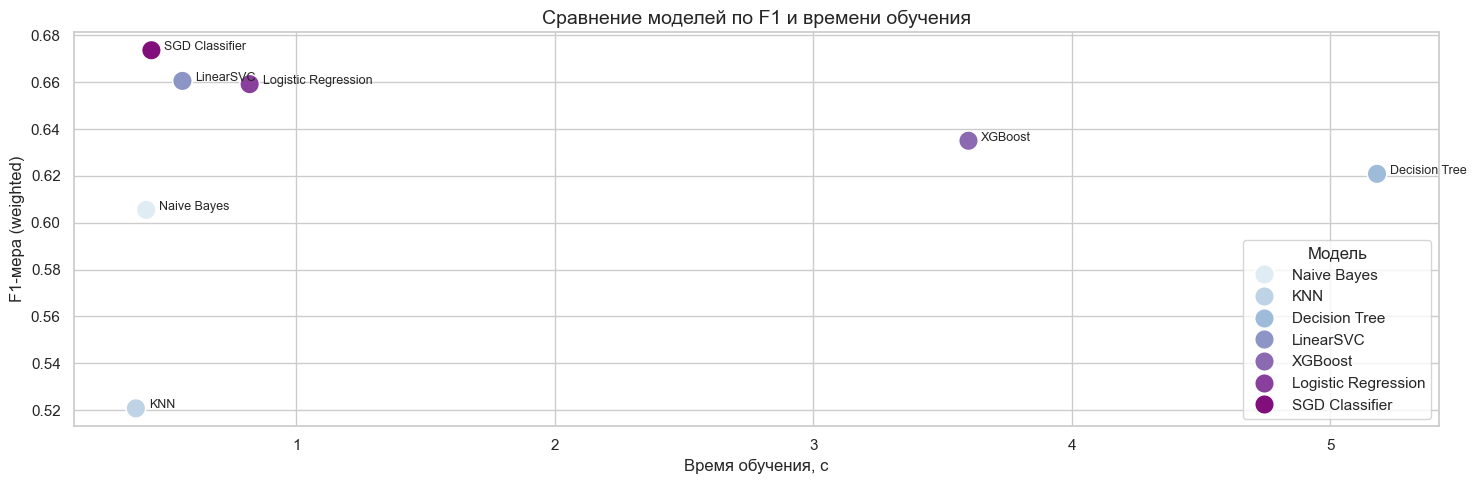

In [62]:
# Визуализация: F1 vs Время обучения
plt.figure(figsize=(15, 5))
sns.scatterplot(
    data=results_df,
    x="Время обучения, с",
    y="F1",
    hue="Модель",
    s=200,
    palette="BuPu"
)

# Подписи точек
for i in range(len(results_df)):
    plt.text(
        results_df["Время обучения, с"][i] + 0.05,
        results_df["F1"][i],
        results_df["Модель"][i],
        fontsize=9
    )

plt.title("Сравнение моделей по F1 и времени обучения", fontsize=14)
plt.xlabel("Время обучения, с")
plt.ylabel("F1-мера (weighted)")
plt.grid(True)
plt.tight_layout()
plt.show()


Модель ближе к левому верхнему углу (`SGD Classifier`) - быстрая и эффективная, поэтому будет использоваться для дальнейшей оптимизации.

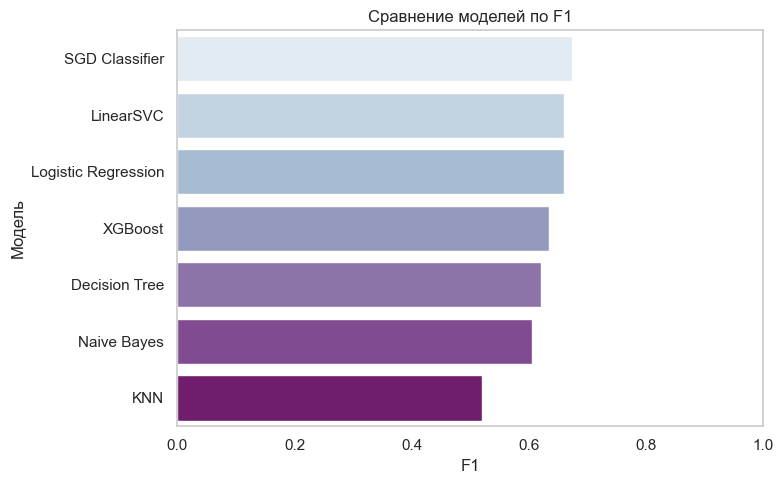

In [63]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df.sort_values("F1", ascending=False),
    x="F1",
    y="Модель",
    hue="Модель",            
    palette="BuPu",
    dodge=False,
    legend=False             
)
plt.title("Сравнение моделей по F1")
plt.xlabel("F1")
plt.ylabel("Модель")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.show()


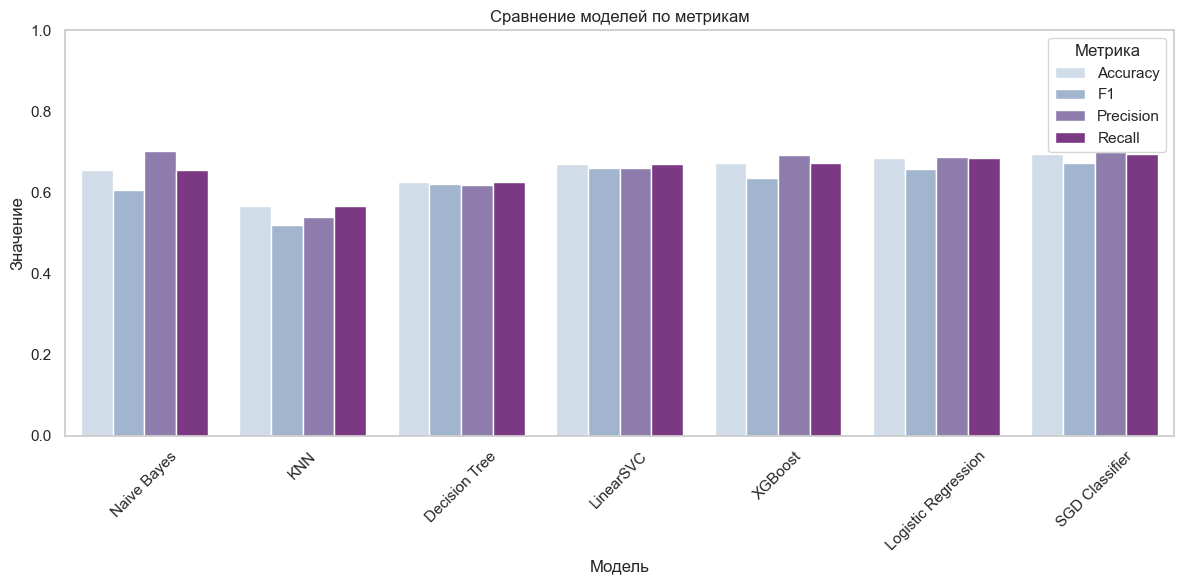

In [64]:
melted = results_df.melt(id_vars="Модель", value_vars=["Accuracy", "F1", "Precision", "Recall"],
                         var_name="Метрика", value_name="Значение")

plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x="Модель", y="Значение", hue="Метрика", palette="BuPu")
plt.title("Сравнение моделей по метрикам")
plt.ylim(0, 1)
plt.ylabel("Значение")
plt.xlabel("Модель")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Вывод по результатам классификации (п. 7)

Сравнение семи моделей показало различия как по качеству классификации, так и по времени обучения.  
Наилучшие результаты продемонстрировал **SGD Classifier**: он достиг наивысшей F1-мeры (0.674) при очень коротком времени обучения (0.44 с), что делает его оптимальным кандидатом для дальнейшей настройки через `GridSearchCV`.

Также высокие показатели показали **Logistic Regression** и **LinearSVC**, уступая SGD незначительно, но оставаясь быстрыми и стабильными.  
**XGBoost** дал хорошие метрики, но требует больше времени (3.6 с) и ресурсов.  
**KNN** и **Naive Bayes** существенно отстают по всем метрикам, особенно по полноте (`Recall`), что делает их менее подходящими.

**Для оптимизации выбрана модель: `SGD Classifier`** как наиболее перспективная по совокупности качества и скорости.


### 8. Оптимизация модели

По результатам сравнительного анализа моделей (см. пункт 7), наилучшее соотношение качества классификации и времени обучения показала модель **SGD Classifier**. Она продемонстрировала наивысшее значение F1-мeры при минимальном времени обучения, что делает её отличным кандидатом для дальнейшей оптимизации.

С целью повышения качества классификации проводится настройка гиперпараметров с использованием метода перебора по сетке (`GridSearchCV`).

Оптимизируемые параметры включают:
- `loss` — функция потерь (`log_loss`, `hinge` и др.);
- `penalty` — тип регуляризации (`l1`, `l2`, `elasticnet`);
- `alpha` — коэффициент регуляризации;
- параметры `TfidfVectorizer`: `max_features`, `ngram_range`.

Оценка эффективности проводится путём сравнения метрик (`F1`, `Precision`, `Recall`) на тестовой выборке до и после настройки.

In [65]:
# Исходная модель (SGDClassifier)
baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words=russian_stopwords)),
    ("clf", SGDClassifier(random_state=42))
])

# Обучение
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# Метрики до оптимизации
metrics_before = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred, average="weighted"),
    "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred, average="weighted")
}

In [87]:
X_train

9534     выборы рязань участок закончиться весь парамет...
16271                   ириш ты одинаковый цветок аватарка
18355    любить любить любить любить любить любить отпр...
1979                       будни школа кушать каша кашалот
19616                 это современный классический слушать
                               ...                        
1535     песня последний встреча беспомощно грудь холод...
18618     блиц интервью военный комиссар орловский область
12945    завтра работа вставать искать киллер срам пове...
19885                                               наташа
12114                                           сёмкий сыр
Name: text_preprocessed, Length: 12173, dtype: object

In [78]:
from sklearn.model_selection import GridSearchCV

# Параметры для настройки
param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__max_features": [10000, 20000],
    "tfidf__min_df": [1, 2],
    "tfidf__sublinear_tf": [True],
    "clf__loss": ["log_loss"],
    "clf__penalty": ["l2", "elasticnet"],
    "clf__alpha": [1e-4, 1e-3, 1e-2],
    "clf__class_weight": [None, "balanced"]
}

# Pipeline с SGDClassifier
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words=russian_stopwords)),
    ("clf", SGDClassifier(random_state=42, max_iter=1000))
])

# Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Обучение с кросс-валидацией
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['и', 'в',
                                                                    'во', 'не',
                                                                    'что', 'он',
                                                                    'на', 'я',
                                                                    'с', 'со',
                                                                    'как', 'а',
                                                                    'то', 'все',
                                                                    'она',
                                                                    'так',
                                                                    'его', 'но',
                                                                    'да', 'ты',
                                                                    'к', 'у',
                                                                    'же', 'вы',
                                                                    'за', 'бы',
                                                                    'по',
                                                                    'только',
                                                                    'ее', 'мне', ...])),
                                       ('clf',
                                        SGDClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.0001, 0.001, 0.01],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__loss': ['log_loss'],
                         'clf__penalty': ['l2', 'elasticnet'],
                         'tfidf__max_features': [10000, 20000],
                         'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__sublinear_tf': [True]},
             scoring='f1_weighted', verbose=2)

In [79]:
# Лучшая модель
best_model = grid_search.best_estimator_
y_pred_after = best_model.predict(X_test)

# Метрики после оптимизации
metrics_after = {
    "Accuracy": accuracy_score(y_test, y_pred_after),
    "F1": f1_score(y_test, y_pred_after, average="weighted"),
    "Precision": precision_score(y_test, y_pred_after, average="weighted"),
    "Recall": recall_score(y_test, y_pred_after, average="weighted")
}

In [83]:
from sklearn.metrics import classification_report

# До оптимизации
print("=== До оптимизации ===")
print(classification_report(y_test, baseline_model.predict(X_test), digits=3))

# После оптимизации
best_model = grid_search.best_estimator_
print("\n=== После оптимизации ===")
print(classification_report(y_test, best_model.predict(X_test), digits=3))

=== До оптимизации ===
              precision    recall  f1-score   support

           0      0.701     0.301     0.421       459
           1      0.685     0.888     0.773      1658
           2      0.722     0.544     0.620       927

    accuracy                          0.694      3044
   macro avg      0.703     0.577     0.605      3044
weighted avg      0.699     0.694     0.674      3044


=== После оптимизации ===
              precision    recall  f1-score   support

           0      0.559     0.431     0.487       459
           1      0.705     0.840     0.767      1658
           2      0.730     0.564     0.637       927

    accuracy                          0.694      3044
   macro avg      0.665     0.612     0.630      3044
weighted avg      0.691     0.694     0.685      3044



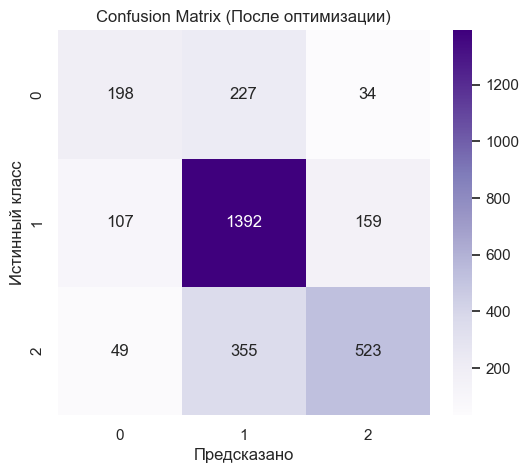

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Предсказано")
plt.ylabel("Истинный класс")
plt.title("Confusion Matrix (После оптимизации)")
plt.show()

In [85]:

comparison_df = pd.DataFrame(
    [metrics_before, metrics_after],
    index=["До оптимизации", "После оптимизации"]
)

comparison_df = comparison_df[["Accuracy", "F1", "Precision", "Recall"]]
comparison_df

,Accuracy,F1,Precision,Recall
До оптимизации,0.694481,0.673552,0.698609,0.694481
После оптимизации,0.694152,0.684832,0.690874,0.694152
